In [8]:
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader
import torch

In [3]:
import torch
print(torch.version.cuda)  # CUDA version PyTorch was built against


11.8


In [24]:
import zarr
import dask.array as da
import s3fs

# Replace with your actual S3 path
s3_path = "s3://allen-genetic-tools/tissuecyte/1340404852/ome_zarr_conversion/1340404852.zarr/"
# Set up anonymous S3 access
fs = s3fs.S3FileSystem(anon=True)
# Create a Zarr store (this skips ome-zarr metadata parsing)
store = fs.get_mapper(s3_path)
# Open zarr group directly (no ome_zarr metadata parsing)
root = zarr.open(store, mode='r')
data_array = root['0']  # load the first array

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import torch
from PIL import Image
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache


#### CODE FROM MODEL TRAIN SCAN TO PRINT ALL SLICES FROM ONE S3

csv_path = "MapMySections_Training.csv"  # CSV with 'STPT Data File Path' and 'Target_Cell_Population'
subclass_csv_path = "subclass_to_index.csv"  # CSV mapping subclass names to indices
batch_size = 4
epochs = 10
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping loader
def get_subclass_to_index_lookup(cache_path="subclass_to_index.csv"):
    cache_path = Path(cache_path)
    print(f"Loading subclass_to_index from {cache_path}")
    df = pd.read_csv(cache_path)
    return dict(zip(df['subclass'], df['index']))


# === Label encoding ===
def get_label_map(csv_path):
    df = pd.read_csv(csv_path)
    labels = sorted(df['label'].unique())
    return {label: idx for idx, label in enumerate(labels)}

# Load label mapping from subclass CSV (subclass -> index)
label_map = get_subclass_to_index_lookup(subclass_csv_path)
num_classes = len(label_map)
print(f"Number of classes: {num_classes}")


# Replace with your actual S3 path
s3_path = "s3://allen-genetic-tools/tissuecyte/1340404852/ome_zarr_conversion/1340404852.zarr/"

# Set up anonymous S3 access
fs = s3fs.S3FileSystem(anon=True)

# Create a Zarr store (this skips ome-zarr metadata parsing)
store = fs.get_mapper(s3_path)

# Try to open the Zarr group and access a dataset
root = zarr.open(store, mode="r")

# Print all available arrays in the store
print("Available datasets:", list(root.array_keys()))

# For example, get the first dataset (commonly '0' for highest-resolution multiscale)
arr = da.from_zarr(root['0'])  # or change to the key printed above

print("Shape:", arr.shape)

csv_path = "MapMySections_Training.csv" 
df = pd.read_csv(csv_path)
df = df[df['Target_Cell_Population'].notnull() & (df['Target_Cell_Population'] != '')]
df = df.reset_index(drop=True)
label_map = label_map

idx = 1

row = df.iloc[idx]
s3_path = row['STPT Data File Path']
label_str = row['Target_Cell_Population']

# Map label to index, fallback or error if missing
if label_str not in label_map:
    raise KeyError(f"Label '{label_str}' not found in label_map")
label = label_map[label_str]

os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""

# Set up anonymous S3 access
fs = s3fs.S3FileSystem(anon=True)
# Create a Zarr store (this skips ome-zarr metadata parsing)
store = fs.get_mapper(s3_path)
# Open zarr group directly (no ome_zarr metadata parsing)
root = zarr.open(store, mode='r')

# Get highest resolution scale (usually 0)
img_np = root['6'][:]  # (C, Z, Y, X)


def normalize(img, clip=99.5):
    max_val = np.percentile(img, clip)
    if max_val < 1e-5:
        max_val = 1.0
    return np.clip(img / max_val, 0, 1)

# Preprocess each Z slice into RGB (Z, H, W, 3)
C, Z, Y, X = img_np.shape
rgb_volume = []

for z in range(Z):
    r = normalize(img_np[0, z])
    g = normalize(img_np[1, z])
    b = normalize(img_np[2, z])

    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    green_threshold = np.percentile(g, 99)
    green_mask = g > green_threshold

    r_final = np.where(green_mask, 0.0, gray)
    g_final = np.where(green_mask, g, gray)
    b_final = np.where(green_mask, 0.0, gray)

    highlighted_rgb = np.stack([r_final, g_final, b_final], axis=-1)  # (H, W, 3)
    rgb_volume.append(highlighted_rgb)

rgb_volume = np.stack(rgb_volume, axis=0)  # (Z, H, W, 3)
rgb_volume = torch.from_numpy(rgb_volume).permute(0, 3, 1, 2).float()  # (Z, 3, H, W)

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

def save_rgb_volume_with_pil(rgb_volume, save_dir, base_name="slice"):
    os.makedirs(save_dir, exist_ok=True)
    rgb_volume = rgb_volume.detach().cpu().numpy()  # (Z, 3, H, W)

    for z in range(rgb_volume.shape[0]):
        img = rgb_volume[z]  # (3, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, 3)
        img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)

        img_pil = Image.fromarray(img_uint8)
        img_pil.save(os.path.join(save_dir, f"{base_name}_z{z:03}.png"))

# Usage example
save_rgb_volume_with_pil(rgb_volume, "./model_training_image_samples/fluo_scan", base_name="FluoScans_")


Loading subclass_to_index from subclass_to_index.csv
Number of classes: 338
Available datasets: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Shape: (3, 142, 29998, 39998)


In [14]:
df['STPT Data File Path'][126]

's3://allen-genetic-tools/tissuecyte/1197776245/ome_zarr_conversion/1197776245.zarr/'

In [ ]:
for s3_path in df['STPT Data File Path']:
    os.environ["AWS_ACCESS_KEY_ID"] = ""
    os.environ["AWS_SECRET_ACCESS_KEY"] = ""

    # Set up anonymous S3 access
    fs = s3fs.S3FileSystem(anon=True)
    # Create a Zarr store (this skips ome-zarr metadata parsing)
    store = fs.get_mapper(s3_path)
    # Open zarr group directly (no ome_zarr metadata parsing)
    root = zarr.open(store, mode='r')

    # Get highest resolution scale (usually 0)
    img_np = root['6'][:]  # (C, Z, Y, X)
    # Preprocess each Z slice into RGB (Z, H, W, 3)
    print(f"{img_np.shape} {s3_path}")


(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1285852977/ome_zarr_conversion/1285852977.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1283915380/ome_zarr_conversion/1283915380.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1121585094/ome-zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1200969502/ome_zarr_conversion/1200969502.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1177798305/ome_zarr_conversion/1177798305.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1195060569/ome_zarr_conversion/1195060569.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1171819575/ome_zarr_conversion/1171819575.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1238484641/ome_zarr_conversion/1238484641.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1346004262/ome_zarr_conversion/1346004262.zarr/
(3, 142, 468, 624) s3://allen-genetic-tools/tissuecyte/1327365632/ome_zarr_conversion/1327365632.zar

KeyboardInterrupt: 

In [20]:
s3_path = "s3://allen-genetic-tools/tissuecyte/1094660644/ome_zarr_conversion/1094660644.zarr/"
# Set up anonymous S3 access
fs = s3fs.S3FileSystem(anon=True)
# Create a Zarr store (this skips ome-zarr metadata parsing)
store = fs.get_mapper(s3_path)
# Open zarr group directly (no ome_zarr metadata parsing)
root = zarr.open(store, mode='r')

# Get highest resolution scale (usually 0)
img_np = root['6'][:]  # (C, Z, Y, X)
# Preprocess each Z slice into RGB (Z, H, W, 3)
print(img_np.shape)

(3, 102, 468, 624)


In [ ]:
import json
zattrs_raw = store['.zattrs']  # returns JSON bytes
metadata = json.loads(zattrs_raw)

# Print relevant OME metadata
print(json.dumps(metadata.get("omero", {})))


{"channels": [{"active": true, "color": "#FF0000", "label": "red", "window": {"min": 0, "start": 0, "end": 795, "max": 65535}}, {"active": true, "color": "#00FF00", "label": "green", "window": {"min": 0, "start": 0, "end": 818, "max": 65535}}, {"active": true, "color": "#0000FF", "label": "blue", "window": {"min": 0, "start": 0, "end": 4095, "max": 65535}}]}


In [ ]:
metadata.items()

NameError: name 'metadata' is not defined

In [ ]:
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

# Example path to S3 OME-Zarr (replace with your own)
zarr_s3_path = "s3://allen-genetic-tools/tissuecyte/1340404852/ome_zarr_conversion/1340404852.zarr/"

store = parse_url(zarr_s3_path)
reader = Reader(store)
nodes = list(reader())
image_node = nodes[0]

# Dask array (lazy-loaded)
dask_array = image_node.data[0]

# Print shape without loading
print(dask_array.shape)


Failed to parse metadata
Traceback (most recent call last):
  File "/Users/inkar.kapen/Desktop/MMC/.venv/lib/python3.13/site-packages/ome_zarr/reader.py", line 364, in __init__
    rgb = [(int(color[i : i + 2], 16) / 255) for i in range(0, 6, 2)]
            ~~~^^^^^^^^^^^^^^^^^^^^^^
ValueError: invalid literal for int() with base 16: '#F'


(3, 142, 29998, 39998)


In [1]:
csv_path = "MapMySections_Training.csv" 
df = pd.read_csv(csv_path)
df = df[df['Target_Cell_Population'].notnull() & (df['Target_Cell_Population'] != '')]
df = df.reset_index(drop=True)

NameError: name 'pd' is not defined

In [ ]:
metadata = image_node.metadata
axes = metadata['axes']
scale = metadata.get('coordinateTransformations', [{}])[0][0].get('scale', None)

print("Axes:", axes)
print("Scale (voxel size) for lowest 0 dim:", scale)


Axes: [{'name': 'c', 'type': 'channel'}, {'name': 'z', 'scale': 0.1, 'type': 'space', 'unit': 'millimeter'}, {'name': 'y', 'scale': 0.00035, 'type': 'space', 'unit': 'millimeter'}, {'name': 'x', 'scale': 0.00035, 'type': 'space', 'unit': 'millimeter'}]
Scale (voxel size) for lowest 0 dim: [1.0, 0.1, 0.00035, 0.00035]


In [ ]:
image_data = image_node.data
high_res_img = image_data[7]  # [0] for the first (highest) scale
# Load the full numpy array from Dask
img_np = high_res_img.compute()  # Now it's a NumPy array  # shape: (3, 142, 58, 78)


In [ ]:
img_np[1, 72].max()

np.uint16(1232)

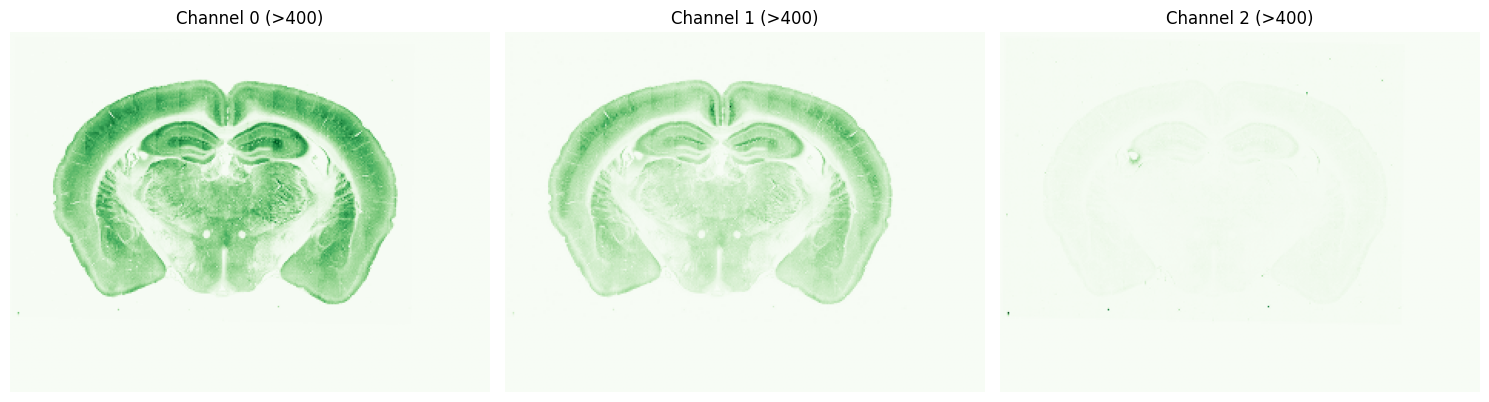

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Choose a Z-slice to view (e.g., middle)
z_index = img_np.shape[1] // 2  # middle Z slice

# Plot each channel in the selected Z slice
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ch in range(3):
    channel_slice = img_np[ch, z_index]

    # Mask values ≤ 400
    masked = np.where(channel_slice > 0, channel_slice, 0)

    axs[ch].imshow(masked, cmap="Greens")
    axs[ch].set_title(f"Channel {ch} (>{400})")
    axs[ch].axis("off")
    axs[ch].set_facecolor("black")  # in case background is visible
plt.tight_layout()
plt.show()


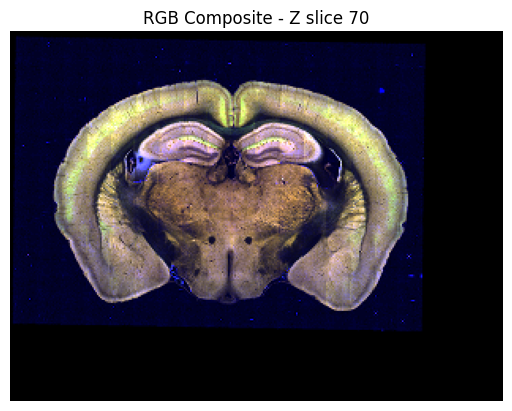

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `img_np` is your (3, Z, Y, X) array
z_index = 70  # choose a Z-slice

# Extract the 3 channels at this Z
r = img_np[0, z_index]
g = img_np[1, z_index]
b = img_np[2, z_index]

# Normalize each channel to 0–1 (robust min-max scaling)
def normalize(img, clip_percentile=99.5):
    max_val = np.percentile(img, clip_percentile)
    return np.clip(img / max_val, 0, 1)

r_norm = normalize(r)
g_norm = normalize(g)
b_norm = normalize(b)

# Stack channels to get RGB image
rgb = np.stack([r_norm, g_norm, b_norm], axis=-1)  # shape: (Y, X, 3)

# Convert to uint8 for visualization
rgb_uint8 = (rgb * 255).astype(np.uint8)

# Display the result
plt.figure()
plt.imshow(rgb_uint8)
plt.title(f"RGB Composite - Z slice {z_index}")
plt.axis("off")
plt.show()


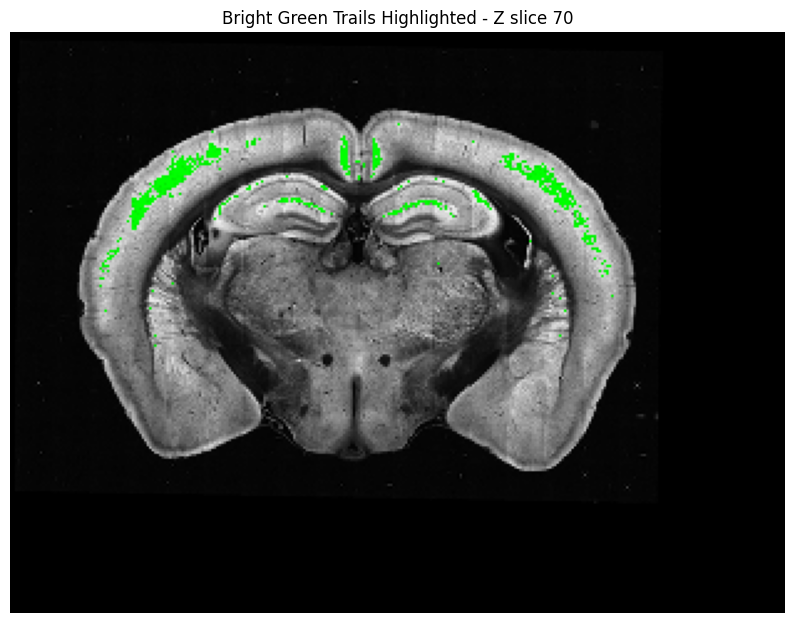

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Z slice
z_index = 70
r = img_np[0, z_index]
g = img_np[1, z_index]
b = img_np[2, z_index]

# Normalize to [0, 1] using percentile-based clipping
def normalize(img, clip=99.5):
    max_val = np.percentile(img, clip)
    return np.clip(img / max_val, 0, 1)

r = normalize(r)
g = normalize(g)
b = normalize(b)

# Convert to grayscale for background
gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

# Use a high threshold — only brightest green stays
green_threshold = np.percentile(g, 99)  # Top 1% of green values
green_mask = g > green_threshold

# Replace background with grayscale
r_final = np.where(green_mask, 0.0, gray)
g_final = np.where(green_mask, g, gray)
b_final = np.where(green_mask, 0.0, gray)

# Stack into RGB
highlighted_rgb = np.stack([r_final, g_final, b_final], axis=-1)
rgb_image = (highlighted_rgb * 255).astype(np.uint8)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title(f"Bright Green Trails Highlighted - Z slice {z_index}")
plt.axis("off")
plt.show()


In [ ]:
import scanpy as sc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

# ==== load atlas ====
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

# ==== load cell data ====
cell = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='cell_metadata_with_cluster_annotation')
cell.rename(columns={'x': 'x_section',
                     'y': 'y_section',
                     'z': 'z_section'},
            inplace=True)
cell.set_index('cell_label', inplace=True)

# ==== load reconst data ====
reconstructed_coords = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='reconstructed_coordinates',
    dtype={"cell_label": str}
)
reconstructed_coords.rename(columns={'x': 'x_reconstructed',
                                     'y': 'y_reconstructed',
                                     'z': 'z_reconstructed'},
                            inplace=True)
reconstructed_coords.set_index('cell_label', inplace=True)

cell_joined = cell.join(reconstructed_coords, how='inner')

# ==== load ccf data ====
ccf_coords = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='ccf_coordinates',
    dtype={"cell_label": str}
)
ccf_coords.rename(columns={'x': 'x_ccf',
                           'y': 'y_ccf',
                           'z': 'z_ccf'},
                  inplace=True)
ccf_coords.drop(['parcellation_index'], axis=1, inplace=True)
ccf_coords.set_index('cell_label', inplace=True)

cell_joined = cell_joined.join(ccf_coords, how='inner')

# ==== load parcellation data ====
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_annotation.head(5)

parcellation_color = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]
parcellation_color.head(5)

cell_joined = cell_joined.join(parcellation_annotation, on='parcellation_index')
cell_joined = cell_joined.join(parcellation_color, on='parcellation_index')
cell_joined.head(5)

# ==== plot func ====
def plot_section(xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,
                 fig_width = 6, fig_height = 6):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if xx is not None and yy is not None and pcmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=pcmap)
    elif xx is not None and yy is not None and cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.', zorder=1)   
        
    if overlay is not None and extent is not None and bcmap is not None:
        plt.imshow(overlay, cmap=bcmap, extent=extent, alpha=alpha, zorder=2)
        
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax



reading resampled_average_template
reading resampled_annotation
reading resampled_annotation_boundary


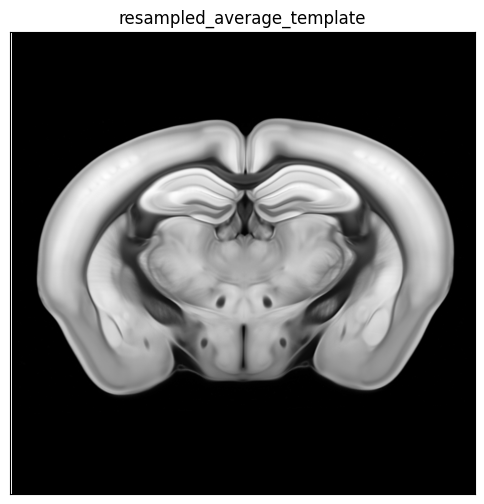

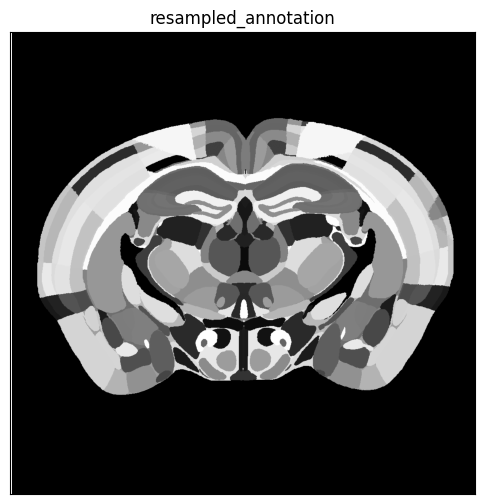

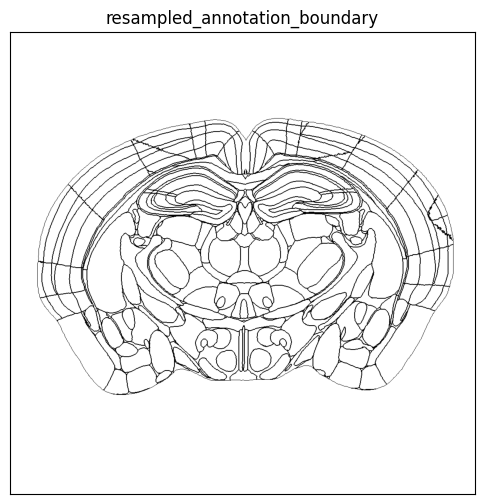

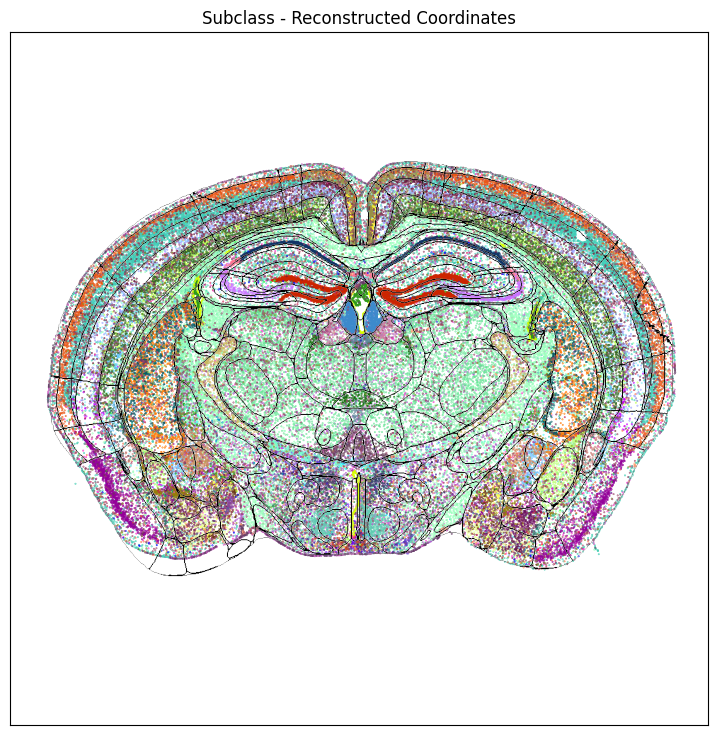

/var/folders/xk/7pk9lv6x2q9dksdmq3f_t9c00000gp/T/ipykernel_81278/1984561535.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section['highlight_color'] = np.where(


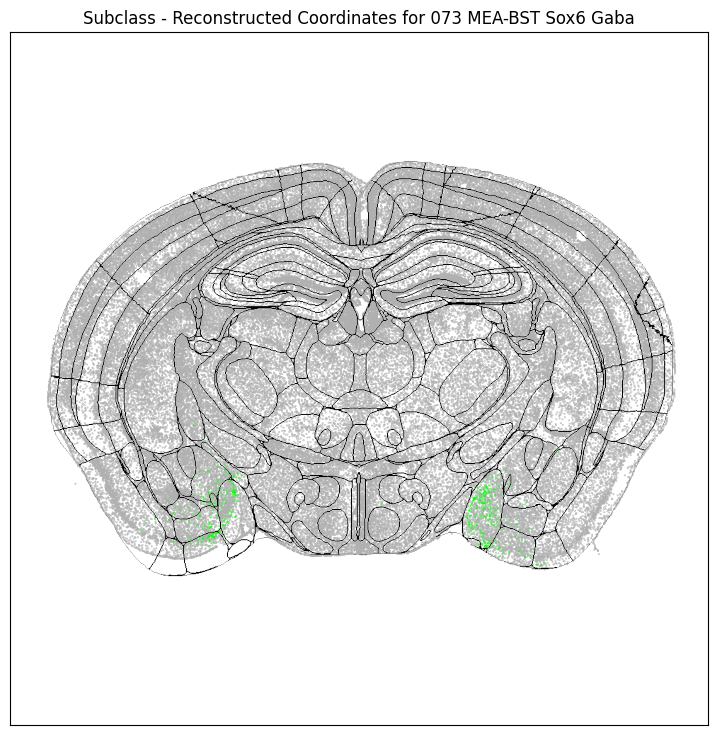

In [ ]:
import random

abc_cache.list_data_files('MERFISH-C57BL6J-638850-CCF')
print("reading resampled_average_template")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_average_template')
average_template_image = sitk.ReadImage(file)
average_template_array = sitk.GetArrayViewFromImage(average_template_image)

print("reading resampled_annotation")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_annotation')
annotation_image = sitk.ReadImage(file)
annotation_array = sitk.GetArrayViewFromImage(annotation_image)

print("reading resampled_annotation_boundary")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_annotation_boundary')
annotation_boundary_image = sitk.ReadImage(file)
annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

size = average_template_image.GetSize()
spacing = average_template_image.GetSpacing()
extent = (-0.5 * spacing[0], (size[0]-0.5) * spacing[0], (size[1]-0.5) * spacing[1], -0.5 * spacing[1])


brain_section = 'C57BL6J-638850.40'
pred = (cell_joined['brain_section_label'] == brain_section)
section = cell_joined.loc[pred].copy()
zindex = int(section.iloc[0]['z_reconstructed'] / 0.2)
zindex

template_slice = average_template_array[zindex, :, :]
fig, ax = plot_section(overlay=template_slice, extent=extent)
res = ax.set_title('resampled_average_template')
plt.show()

annotation_slice = annotation_array[zindex, :, :]
fig, ax = plot_section(overlay=annotation_slice, extent=extent)
res = ax.set_title('resampled_annotation')
plt.show()

boundary_slice = annotation_boundary_array[zindex, :, :]
fig, ax = plot_section(overlay=boundary_slice, bcmap=plt.cm.Greys, extent=extent)
res = ax.set_title('resampled_annotation_boundary')
plt.show()


fig, ax = plot_section(section['x_reconstructed'],
                       section['y_reconstructed'], 
                       cc=section['subclass_color'],
                       overlay=boundary_slice,
                       extent=extent, 
                       bcmap=plt.cm.Greys,
                       alpha = 1.0*(boundary_slice>0),
                       fig_width = 9,
                       fig_height = 9 )
res = ax.set_title("Subclass - Reconstructed Coordinates")
plt.show()

# ==== make it fluorescent ====
# Define the subclass to highlight
target_subclass = random.choice(section['subclass'].unique())

# Define the fluorescent green color (hex or RGB tuple)
fluorescent_green = "#00FF00"  # or (0, 1, 0) if using RGB floats

# Set colors: green for target subclass, grey for others
section['highlight_color'] = np.where(
    section['subclass'] == target_subclass,
    fluorescent_green,
    "#B0B0B0"  # light grey
)
fig, ax = plot_section(section['x_reconstructed'],
                       section['y_reconstructed'], 
                       cc=section['highlight_color'],
                       overlay=boundary_slice,
                       extent=extent, 
                       bcmap=plt.cm.Greys,
                       alpha = 1.0*(boundary_slice>0),
                       fig_width = 9,
                       fig_height = 9 )
res = ax.set_title(f"Subclass - Reconstructed Coordinates for {target_subclass}")
plt.show()

/var/folders/xk/7pk9lv6x2q9dksdmq3f_t9c00000gp/T/ipykernel_81278/3503388538.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section['highlight_color'] = np.where(


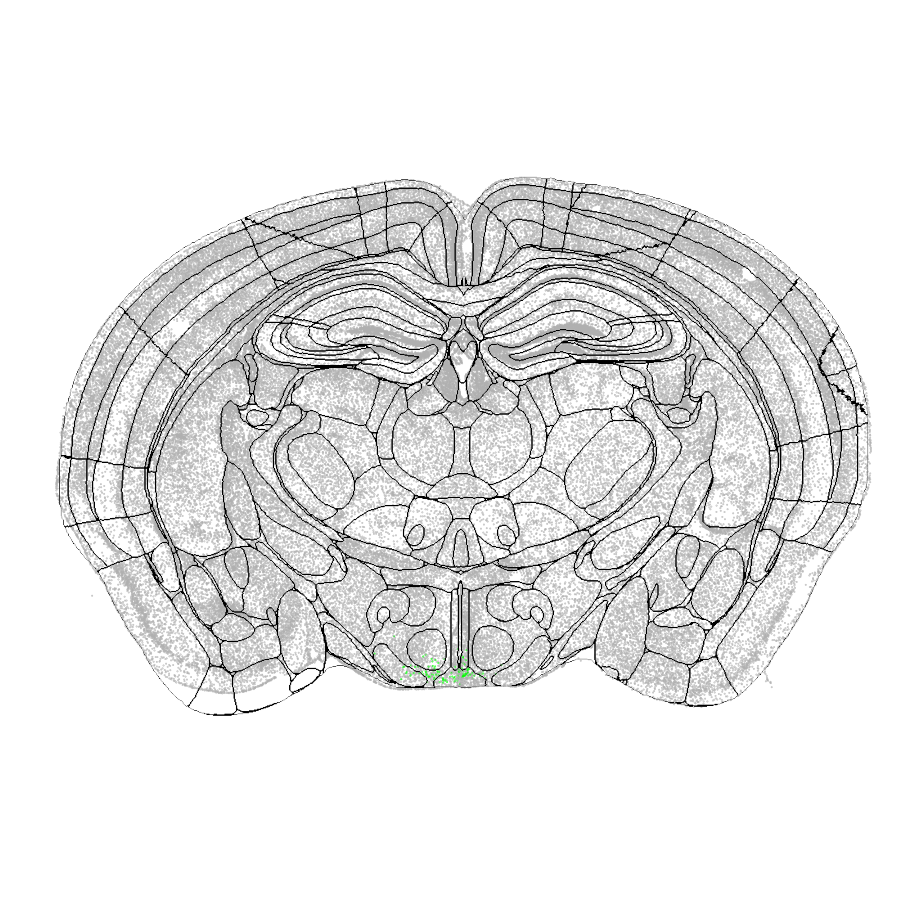

In [ ]:
import torch
# Define the fluorescent green color (hex or RGB tuple)
fluorescent_green = "#00FF00"  # or (0, 1, 0) if using RGB floats

# Set colors: green for target subclass, grey for others
section['highlight_color'] = np.where(
    section['subclass'] == target_subclass,
    fluorescent_green,
    "#B0B0B0"  # light grey
)
fig, ax = plot_section(section['x_reconstructed'],
                    section['y_reconstructed'], 
                    cc=section['highlight_color'],
                    overlay=boundary_slice,
                    extent=extent, 
                    bcmap=plt.cm.Greys,
                    alpha = 1.0*(boundary_slice>0),
                    fig_width = 9,
                    fig_height = 9 )

# Remove whitespace and axes
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# --- Render to image buffer ---
fig.canvas.draw()
w, h = fig.canvas.get_width_height()
buf = fig.canvas.buffer_rgba()
img = Image.frombuffer('RGBA', (w, h), buf, 'raw', 'RGBA', 0, 1).convert('RGB')

# Optional: resize to desired training input shape
img = img.resize((900, 900))  # or (224, 224), etc.

# Convert to NumPy array, normalize [0,1], and to tensor
img_np = np.array(img).astype(np.float32) / 255.0
img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # shape: (3, H, W)

# (Optional) Batchify for input to model
img_tensor = img_tensor.unsqueeze(0)  # shape: (1, 3, H, W)

plt.close(fig)  # Close the figure to avoid memory leaks

In [ ]:
section[['subclass', 'cluster', 'x_reconstructed', 'y_reconstructed']]

,subclass,cluster,x_reconstructed,y_reconstructed
cell_label,,,,
1019171907201490388,038 DG-PIR Ex IMN,0515 DG-PIR Ex IMN_2,6.361979,4.087858
1019171907101490466,038 DG-PIR Ex IMN,0515 DG-PIR Ex IMN_2,6.390062,4.202825
1019171907202030406,038 DG-PIR Ex IMN,0514 DG-PIR Ex IMN_2,4.903712,4.082049
1019171907102030864,038 DG-PIR Ex IMN,0515 DG-PIR Ex IMN_2,4.788024,4.176661
1019171907201500210,038 DG-PIR Ex IMN,0515 DG-PIR Ex IMN_2,6.448701,4.186050
...,...,...,...,...
1019171907103110107,333 Endo NN,5309 Endo NN_1,2.306725,4.701274
1019171907102100239,333 Endo NN,5310 Endo NN_1,5.639457,7.102166
1019171907200750373,333 Endo NN,5309 Endo NN_1,7.971446,2.818269


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import torch
from PIL import Image

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

# get cell type and coordinated xyz data
def get_cell_joined_data(abc_cache):
    # ==== load cell data ====
    cell = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='cell_metadata_with_cluster_annotation')
    cell.rename(columns={'x': 'x_section',
                        'y': 'y_section',
                        'z': 'z_section'},
                inplace=True)
    cell.set_index('cell_label', inplace=True)

    # ==== load reconst data ====
    reconstructed_coords = abc_cache.get_metadata_dataframe(
        directory='MERFISH-C57BL6J-638850-CCF',
        file_name='reconstructed_coordinates',
        dtype={"cell_label": str}
    )
    reconstructed_coords.rename(columns={'x': 'x_reconstructed',
                                        'y': 'y_reconstructed',
                                        'z': 'z_reconstructed'},
                                inplace=True)
    reconstructed_coords.set_index('cell_label', inplace=True)

    cell_joined = cell.join(reconstructed_coords, how='inner')

    # ==== load ccf data ====
    ccf_coords = abc_cache.get_metadata_dataframe(
        directory='MERFISH-C57BL6J-638850-CCF',
        file_name='ccf_coordinates',
        dtype={"cell_label": str}
    )
    ccf_coords.rename(columns={'x': 'x_ccf',
                            'y': 'y_ccf',
                            'z': 'z_ccf'},
                    inplace=True)
    ccf_coords.drop(['parcellation_index'], axis=1, inplace=True)
    ccf_coords.set_index('cell_label', inplace=True)

    cell_joined = cell_joined.join(ccf_coords, how='inner')

    # ==== load parcellation data ====
    parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                            file_name='parcellation_to_parcellation_term_membership_acronym')
    parcellation_annotation.set_index('parcellation_index', inplace=True)
    parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

    parcellation_color = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                        file_name='parcellation_to_parcellation_term_membership_color')
    parcellation_color.set_index('parcellation_index', inplace=True)
    parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

    cell_joined = cell_joined.join(parcellation_annotation, on='parcellation_index')
    cell_joined = cell_joined.join(parcellation_color, on='parcellation_index')

    return cell_joined


def get_ccf_data(abc_cache, cell_joined):
    abc_cache.list_data_files('MERFISH-C57BL6J-638850-CCF')
    print("reading resampled_average_template")
    file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                                file_name='resampled_average_template')
    average_template_image = sitk.ReadImage(file)

    print("reading resampled_annotation_boundary")
    file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                                file_name='resampled_annotation_boundary')
    annotation_boundary_image = sitk.ReadImage(file)
    annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

    return average_template_image, annotation_boundary_array

# ==== plot func ====
def plot_section(xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,
                 fig_width = 6, fig_height = 6):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if xx is not None and yy is not None and pcmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=pcmap)
    elif xx is not None and yy is not None and cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.', zorder=1)   
        
    if overlay is not None and extent is not None and bcmap is not None:
        plt.imshow(overlay, cmap=bcmap, extent=extent, alpha=alpha, zorder=2)
        
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

def generate_tensor_images(section, target_subclass, boundary_slice, average_template_image):
    # calculate ccf overlay
    size = average_template_image.GetSize()
    spacing = average_template_image.GetSpacing()
    extent = (-0.5 * spacing[0], (size[0]-0.5) * spacing[0], (size[1]-0.5) * spacing[1], -0.5 * spacing[1])
    
    # ==== make it fluorescent ====
    # Define the fluorescent green color (hex or RGB tuple)
    fluorescent_green = "#00FF00"  # or (0, 1, 0) if using RGB floats

    # Set colors: green for target subclass, grey for others
    section['highlight_color'] = np.where(
        section['subclass'] == target_subclass,
        fluorescent_green,
        "#B0B0B0"  # light grey
    )
    fig, ax = plot_section(section['x_reconstructed'],
                        section['y_reconstructed'], 
                        cc=section['highlight_color'],
                        overlay=boundary_slice,
                        extent=extent, 
                        bcmap=plt.cm.Greys,
                        alpha = 1.0*(boundary_slice>0),
                        fig_width = 9,
                        fig_height = 9 )

    # Remove whitespace and axes
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # --- Render to image buffer ---
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = fig.canvas.buffer_rgba()
    img = Image.frombuffer('RGBA', (w, h), buf, 'raw', 'RGBA', 0, 1).convert('RGB')

    # Optional: resize to desired training input shape
    img = img.resize((512, 512))  # or (224, 224), etc.

    # Convert to NumPy array, normalize [0,1], and to tensor
    img_np = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # shape: (3, H, W)

    # (Optional) Batchify for input to model
    img_tensor = img_tensor.unsqueeze(0)  # shape: (1, 3, H, W)
    plt.close(fig)  # Close the figure to avoid memory leaks

    return img_tensor


def save_tensor_image(img_tensor, brain_section, subclass):
    # If batched, remove batch dimension: (1, 3, H, W) → (3, H, W)
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]

    # Convert to NumPy (H, W, 3)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

    # Optional: clip just in case
    img_np = np.clip(img_np, 0, 1)

    # Set target DPI
    dpi = 300
    height, width = img_np.shape[:2]
    figsize = (width / dpi, height / dpi)

    # Plot with high DPI
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(img_np)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f"./model_training_image_samples/{brain_section}__{subclass}.png", dpi=dpi, bbox_inches='tight', pad_inches=0)

    plt.close(fig)


# replaced by OnTheFlyTensorDataset __getitem__
def process_image_data():
    # ==== load atlas ====
    download_base = Path('../../data/abc_atlas')
    abc_cache = AbcProjectCache.from_cache_dir(download_base)

    cell_joined = get_cell_joined_data(abc_cache)
    average_template_image, annotation_boundary_array = get_ccf_data(abc_cache, cell_joined)

    image_tensors = []
    labels = []
    brain_section_labels = cell_joined['brain_section_label'].unique().tolist()

    i = 0
    for brain_section in brain_section_labels:
        pred = (cell_joined['brain_section_label'] == brain_section)
        section = cell_joined.loc[pred].copy()
        zindex = int(section.iloc[0]['z_reconstructed'] / 0.2)
        boundary_slice = annotation_boundary_array[zindex, :, :]

        # Define the subclass to highlight
        target_subclasses = section['subclass'].unique()

        for target_subclass in target_subclasses:
            img_tensor = generate_tensor_images(section, target_subclass, boundary_slice, average_template_image)
            image_tensors.append(img_tensor[0])  # remove batch dim
            labels.append(target_subclass)
            # save some samples
            if i % 10000 == 0:
                save_tensor_image(img_tensor, brain_section, target_subclass)
            i += 1
    return image_tensors, labels



from torch.utils.data import Dataset
import torch

class OnTheFlyTensorDataset(Dataset):
    def __init__(self, metadata_df, cell_joined, average_template_image, boundary_array, label_encoder, transform=None):
        self.meta = metadata_df.reset_index(drop=True)
        self.cell_joined = cell_joined
        self.atlas_img = average_template_image
        self.boundary_array = boundary_array
        self.label_encoder = label_encoder
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        brain_section = row['brain_section_label']
        subclass = row['subclass']
        
        section = self.cell_joined.loc[self.cell_joined['brain_section_label'] == brain_section].copy()
        zindex = int(section.iloc[0]['z_reconstructed'] / 0.2)
        boundary_slice = self.boundary_array[zindex, :, :]

        img_tensor = generate_tensor_images(section, subclass, boundary_slice, self.atlas_img)
        label = self.label_encoder[subclass]

        # Optional image transform (augmentation, resizing)
        if self.transform:
            img_tensor = self.transform(img_tensor)
        print(f"Get Image # {label}")
        #save_tensor_image(img_tensor, brain_section, label)
        return img_tensor.squeeze(0), label

import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

def get_subclass_to_index_lookup(cell_joined, cache_path="cache/subclass_to_index.csv"):
    cache_path = Path(cache_path)

    if cache_path.exists():
        print(f"Loading subclass_to_index from {cache_path}")
        df = pd.read_csv(cache_path)
        return dict(zip(df['subclass'], df['index']))

    print("Generating subclass_to_index from cell_joined")
    label_encoder = LabelEncoder()
    label_encoder.fit(cell_joined['subclass'])

    subclass_to_index = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Save to CSV
    df = pd.DataFrame(list(subclass_to_index.items()), columns=["subclass", "index"])
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(cache_path, index=False)

    return subclass_to_index


print('==== load atlas ====')
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

cell_joined = get_cell_joined_data(abc_cache)
average_template_image, annotation_boundary_array = get_ccf_data(abc_cache, cell_joined)


==== load atlas ====
reading resampled_average_template
reading resampled_annotation_boundary


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(cell_joined['subclass'])
subclass_to_index = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


print('2. Transforms and DataLoaders')
from sklearn.model_selection import train_test_split

metadata_df = cell_joined[['brain_section_label', 'subclass']].drop_duplicates()
# Prepare stratified group split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Split using subclass as the stratify label, and brain_section_label as the group
for train_idx, val_idx in sgkf.split(metadata_df, y=metadata_df['subclass'], groups=metadata_df['brain_section_label']):
    train_df = metadata_df.iloc[train_idx].reset_index(drop=True)
    val_df = metadata_df.iloc[val_idx].reset_index(drop=True)
    break  # Only need the first split

# Dataloaders
from torch.utils.data import DataLoader

train_dataset = OnTheFlyTensorDataset(train_df, cell_joined, average_template_image, annotation_boundary_array, subclass_to_index)
val_dataset = OnTheFlyTensorDataset(val_df, cell_joined, average_template_image, annotation_boundary_array, subclass_to_index)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print('3. Model Setup (ResNet18)')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Assume this is already defined
num_classes = len(subclass_to_index)  # e.g., 338

# Initialize model
model = models.resnet18(weights=None)
state_dict = torch.load("./resnet18/resnet18-f37072fd.pth")
model.load_state_dict(state_dict)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print('4. Training + Validation Loop')
import torch.nn.functional as F
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_top1 = 0
    correct_top3 = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        print("Train one epoch loss and optimizer")
        loss = F.cross_entropy(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += labels.size(0)

        print("Train one epoch softmax")
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_classes = probs.topk(3, dim=1)

        print("Train one epoch score calculation")
        correct_top1 += (top_classes[:, 0] == labels).sum().item()
        correct_top3 += (top_classes == labels.unsqueeze(1)).any(dim=1).sum().item()

    return total_loss / len(loader), correct_top1 / total, correct_top3 / total


def validate(model, loader, device):
    model.eval()
    total_loss = 0
    correct_top1 = 0
    correct_top3 = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item()
            total += labels.size(0)

            probs = torch.softmax(outputs, dim=1)
            top_probs, top_classes = probs.topk(3, dim=1)

            correct_top1 += (top_classes[:, 0] == labels).sum().item()
            correct_top3 += (top_classes == labels.unsqueeze(1)).any(dim=1).sum().item()

    return total_loss / len(loader), correct_top1 / total, correct_top3 / total


# Example Training Loop
from torch.utils.data import DataLoader
from torch.optim import Adam

print("Loading train and val data")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 10

best_val_acc = 0.0
best_model_path = "./resnet18/best_model.pth"

for epoch in range(epochs):
    print('train one epoch')
    train_loss, train_acc1, train_acc3 = train_one_epoch(model, train_loader, optimizer, device)
    print('validate')
    val_loss, val_acc1, val_acc3 = validate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Top-1 Acc: {train_acc1:.4f}, Top-3 Acc: {train_acc3:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Top-1 Acc: {val_acc1:.4f}, Top-3 Acc: {val_acc3:.4f}")
    
    if val_acc1 > best_val_acc:
        print('4. Save the best model')
        best_val_acc = val_acc1
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} with acc {best_val_acc:.4f}")


2. Transforms and DataLoaders


/Users/inkar.kapen/Desktop/MMC/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


3. Model Setup (ResNet18)
4. Training + Validation Loop
Loading train and val data
train one epoch


Training:   0%|          | 0/149 [00:00<?, ?it/s]

Get Image # 318
Get Image # 198
Get Image # 164
Get Image # 56
Get Image # 220
Get Image # 82
Get Image # 100
Get Image # 286
Get Image # 223
Get Image # 242
Get Image # 186
Get Image # 75
Get Image # 194
Get Image # 168
Get Image # 60
Get Image # 303
Get Image # 336
Get Image # 333
Get Image # 42
Get Image # 133
Get Image # 42
Get Image # 194
Get Image # 27
Get Image # 328
Get Image # 6
Get Image # 191
Get Image # 201
Get Image # 57
Get Image # 320
Get Image # 223
Get Image # 66
Get Image # 17
Train one epoch loss and optimizer


Training:   1%|          | 1/149 [00:36<1:31:03, 36.91s/it]

Train one epoch softmax
Train one epoch score calculation
Get Image # 29
Get Image # 50
Get Image # 71
Get Image # 220
Get Image # 59
Get Image # 324
Get Image # 28
Get Image # 172
Get Image # 136
Get Image # 65
Get Image # 317
Get Image # 331
Get Image # 250
Get Image # 337
Get Image # 332
Get Image # 99
Get Image # 40
Get Image # 52
Get Image # 286
Get Image # 45
Get Image # 264
Get Image # 337
Get Image # 214
Get Image # 186
Get Image # 106
Get Image # 23
Get Image # 2
Get Image # 250
Get Image # 227
Get Image # 194
Get Image # 181
Get Image # 242
Train one epoch loss and optimizer


Training:   1%|▏         | 2/149 [01:13<1:30:13, 36.83s/it]

Train one epoch softmax
Train one epoch score calculation


: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import torch
from PIL import Image
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache


# get cell type and coordinated xyz data
def get_cell_joined_data(abc_cache):
    # ==== load cell data ====
    cell = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='cell_metadata_with_cluster_annotation')
    cell.rename(columns={'x': 'x_section',
                        'y': 'y_section',
                        'z': 'z_section'},
                inplace=True)
    cell.set_index('cell_label', inplace=True)

    # ==== load reconst data ====
    reconstructed_coords = abc_cache.get_metadata_dataframe(
        directory='MERFISH-C57BL6J-638850-CCF',
        file_name='reconstructed_coordinates',
        dtype={"cell_label": str}
    )
    reconstructed_coords.rename(columns={'x': 'x_reconstructed',
                                        'y': 'y_reconstructed',
                                        'z': 'z_reconstructed'},
                                inplace=True)
    reconstructed_coords.set_index('cell_label', inplace=True)

    cell_joined = cell.join(reconstructed_coords, how='inner')

    # ==== load ccf data ====
    ccf_coords = abc_cache.get_metadata_dataframe(
        directory='MERFISH-C57BL6J-638850-CCF',
        file_name='ccf_coordinates',
        dtype={"cell_label": str}
    )
    ccf_coords.rename(columns={'x': 'x_ccf',
                            'y': 'y_ccf',
                            'z': 'z_ccf'},
                    inplace=True)
    ccf_coords.drop(['parcellation_index'], axis=1, inplace=True)
    ccf_coords.set_index('cell_label', inplace=True)

    cell_joined = cell_joined.join(ccf_coords, how='inner')

    # ==== load parcellation data ====
    parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                            file_name='parcellation_to_parcellation_term_membership_acronym')
    parcellation_annotation.set_index('parcellation_index', inplace=True)
    parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

    parcellation_color = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                        file_name='parcellation_to_parcellation_term_membership_color')
    parcellation_color.set_index('parcellation_index', inplace=True)
    parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

    cell_joined = cell_joined.join(parcellation_annotation, on='parcellation_index')
    cell_joined = cell_joined.join(parcellation_color, on='parcellation_index')

    return cell_joined


def get_ccf_data(abc_cache, cell_joined):
    abc_cache.list_data_files('MERFISH-C57BL6J-638850-CCF')
    print("reading resampled_average_template")
    file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                                file_name='resampled_average_template')
    average_template_image = sitk.ReadImage(file)

    print("reading resampled_annotation_boundary")
    file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                                file_name='resampled_annotation_boundary')
    annotation_boundary_image = sitk.ReadImage(file)
    annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

    return average_template_image, annotation_boundary_array

# ==== plot func ====
def plot_section(xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,
                 fig_width = 6, fig_height = 6):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if xx is not None and yy is not None and pcmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=pcmap)
    elif xx is not None and yy is not None and cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.', zorder=1)   
        
    if overlay is not None and extent is not None and bcmap is not None:
        plt.imshow(overlay, cmap=bcmap, extent=extent, alpha=alpha, zorder=2)
        
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

def generate_tensor_images(section, target_subclass, boundary_slice, average_template_image):
    # calculate ccf overlay
    size = average_template_image.GetSize()
    spacing = average_template_image.GetSpacing()
    extent = (-0.5 * spacing[0], (size[0]-0.5) * spacing[0], (size[1]-0.5) * spacing[1], -0.5 * spacing[1])
    
    fluorescent_green = "#00FF00"
    section['highlight_color'] = np.where(
        section['subclass'] == target_subclass,
        fluorescent_green,
        "#B0B0B0"
    )
    fig, ax = plot_section(section['x_reconstructed'], section['y_reconstructed'], 
                          cc=section['highlight_color'], overlay=boundary_slice,
                          extent=extent, bcmap=plt.cm.Greys, alpha=1.0*(boundary_slice>0),
                          fig_width=6, fig_height=6)

    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = fig.canvas.buffer_rgba()
    img = Image.frombuffer('RGBA', (w, h), buf, 'raw', 'RGBA', 0, 1).convert('RGB')

    # Resize to smaller dimension for 3D stacking (change as needed)
    img = img.resize((512, 512))

    img_np = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # (3, H, W)

    img_tensor = img_tensor.unsqueeze(0)  # (1, 3, H, W)
    plt.close(fig)

    return img_tensor


def save_tensor_image(img_tensor, brain_section, subclass):
    # If batched, remove batch dimension: (1, 3, H, W) → (3, H, W)
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]

    # Convert to NumPy (H, W, 3)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

    # Optional: clip just in case
    img_np = np.clip(img_np, 0, 1)

    # Set target DPI
    dpi = 300
    height, width = img_np.shape[:2]
    figsize = (width / dpi, height / dpi)

    # Plot with high DPI
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(img_np)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f"./model_training_image_samples/merfish/{brain_section}__{subclass}.png", dpi=dpi, bbox_inches='tight', pad_inches=0)

    plt.close(fig)


# replaced by OnTheFlyTensorDataset __getitem__
def process_image_data():
    # ==== load atlas ====
    download_base = Path('../../data/abc_atlas')
    abc_cache = AbcProjectCache.from_cache_dir(download_base)

    cell_joined = get_cell_joined_data(abc_cache)
    average_template_image, annotation_boundary_array = get_ccf_data(abc_cache, cell_joined)

    image_tensors = []
    labels = []
    brain_section_labels = cell_joined['brain_section_label'].unique().tolist()

    i = 0
    for brain_section in brain_section_labels:
        pred = (cell_joined['brain_section_label'] == brain_section)
        section = cell_joined.loc[pred].copy()
        zindex = int(section.iloc[0]['z_reconstructed'] / 0.2)
        boundary_slice = annotation_boundary_array[zindex, :, :]

        # Define the subclass to highlight
        target_subclasses = section['subclass'].unique()

        for target_subclass in target_subclasses:
            img_tensor = generate_tensor_images(section, target_subclass, boundary_slice, average_template_image)
            image_tensors.append(img_tensor[0])  # remove batch dim
            labels.append(target_subclass)
            # save some samples
            if i % 10000 == 0:
                save_tensor_image(img_tensor, brain_section, target_subclass)
            i += 1
    return image_tensors, labels


def get_subclass_to_index_lookup(cell_joined, cache_path="subclass_to_index.csv"):
    cache_path = Path(cache_path)

    if cache_path.exists():
        print(f"Loading subclass_to_index from {cache_path}")
        df = pd.read_csv(cache_path)
        return dict(zip(df['subclass'], df['index']))

    print("Generating subclass_to_index from cell_joined")
    label_encoder = LabelEncoder()
    label_encoder.fit(cell_joined['subclass'])

    subclass_to_index = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    df = pd.DataFrame(list(subclass_to_index.items()), columns=["subclass", "index"])
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(cache_path, index=False)

    return subclass_to_index


print('==== load atlas ====')
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

cell_joined = get_cell_joined_data(abc_cache)
average_template_image, annotation_boundary_array = get_ccf_data(abc_cache, cell_joined)

subclass_to_index = get_subclass_to_index_lookup(cell_joined)


metadata_df = cell_joined[['brain_section_label', 'subclass']].drop_duplicates()
atlas_img = average_template_image
boundary_array = annotation_boundary_array
label_encoder = subclass_to_index

subclasses = sorted(cell_joined['subclass'].unique())

subclass_to_sections = defaultdict(list)
for subclass in subclasses:
    df = cell_joined[cell_joined['subclass'] == subclass]
    groups = df.groupby('brain_section_label')
    for brain_section_label, group in groups:
        zindex = int(group.iloc[0]['z_reconstructed'] / 0.2)
        subclass_to_sections[subclass].append((zindex, group))

idx = 1
subclass = subclasses[idx]
sections = subclass_to_sections[subclass]

tensor_slices = []
z_indices = []

for zindex, section in sections:
    #if 0 <= zindex < self.boundary_array.shape[0]:
    boundary_slice = boundary_array[zindex, :, :]
    img_tensor = generate_tensor_images(section, subclass, boundary_slice, atlas_img)
    tensor_slices.append(img_tensor.squeeze(0))  # (3, H, W)
    z_indices.append(zindex)

# z_indices already confirmed to be a list of ints
sorted_pairs = sorted(zip(z_indices, tensor_slices), key=lambda x: x[0])
sorted_slices = [t for _, t in sorted_pairs]

volume_tensor = torch.stack(sorted_slices, dim=0).permute(1, 0, 2, 3)  # (3, D, H, W)

for i in range(36):
    save_tensor_image(volume_tensor[:, i, :, :], 'merfish', i)

==== load atlas ====
reading resampled_average_template
reading resampled_annotation_boundary
Loading subclass_to_index from subclass_to_index.csv


In [62]:
set(df['Target_Cell_Population']) - set(cell_joined[cell_joined['parcellation_division'] == 'Isocortex']['subclass'].values)

set()